In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

First we will import the JSON of logins, and check the type and first five entries.

In [29]:
df = pd.read_json('logins.json')

In [31]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [32]:
df.dtypes

login_time    datetime64[ns]
dtype: object

Next we want to arrange the data in 15 minute time intervals.

In [33]:
df.shape

(93142, 1)

In [34]:
df.columns

Index(['login_time'], dtype='object')

In [36]:
df = df.set_index('login_time')
df['Counter'] = 0
df = df.resample('15min').count()
df = df.reset_index()

In [37]:
df.columns

Index(['login_time', 'Counter'], dtype='object')

In [38]:
df.head()

,login_time,Counter
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


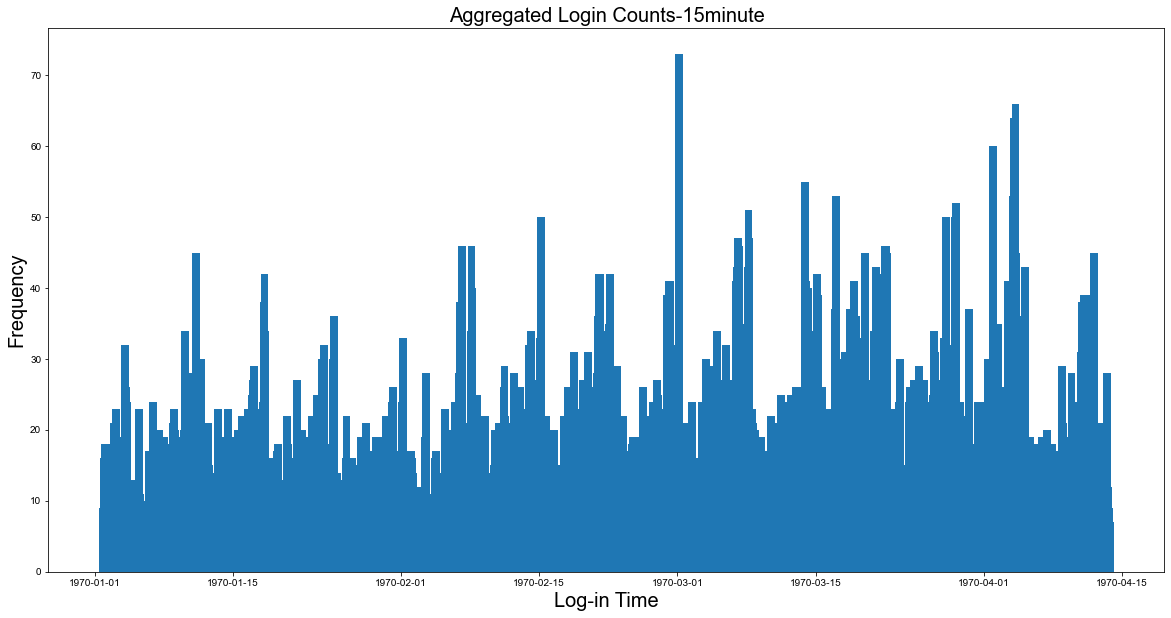

In [42]:
plt.figure(figsize=(20, 10))
plt.bar(df.login_time, df.Counter, data=df)
plt.xlabel('Log-in Time', size = 20)
plt.ylabel('Frequency', size = 20)
plt.title('Aggregated Login Counts-15minute', size = 20)
sns.set()

Next we will look at the daily cycles. 

In [43]:
df['Day'] = df.login_time.dt.day_name()
df

,login_time,Counter,Day
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday
...,...,...,...
9783,1970-04-13 17:45:00,5,Monday
9784,1970-04-13 18:00:00,5,Monday
9785,1970-04-13 18:15:00,2,Monday
9786,1970-04-13 18:30:00,7,Monday


In [44]:
day_logins = df.groupby('Day', as_index=False, sort='').sum()
day_logins.sort_values('Counter', ascending=False)

,Day,Counter
2,Saturday,19377
3,Sunday,18167
1,Friday,15208
0,Thursday,11960
6,Wednesday,10339
5,Tuesday,9268
4,Monday,8823


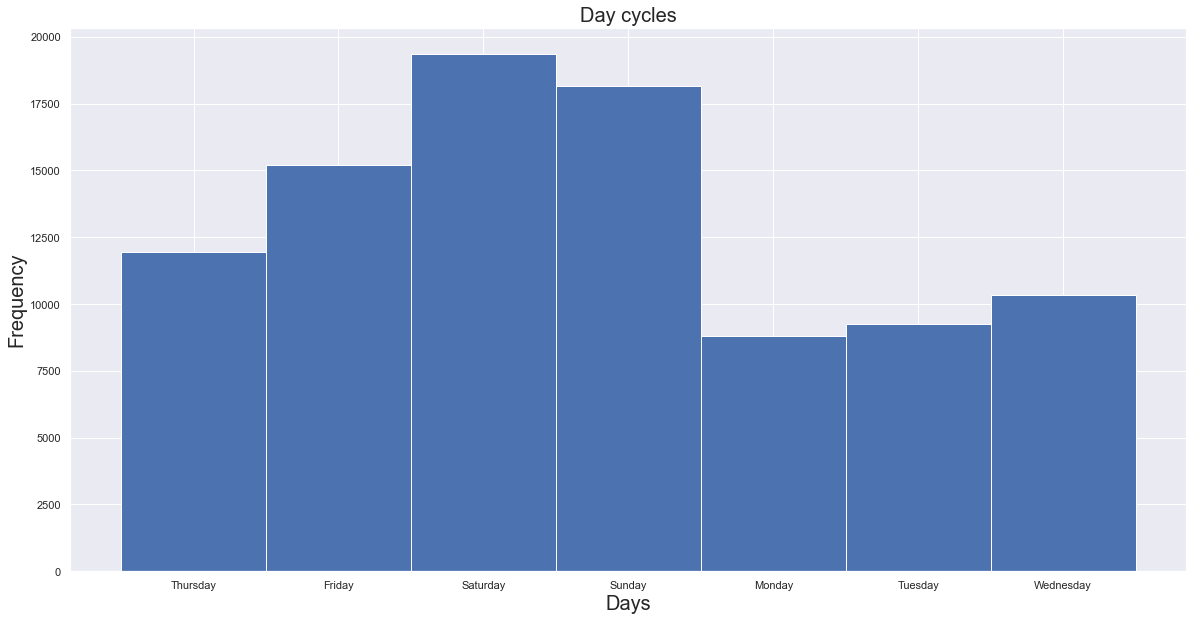

In [45]:
plt.figure(figsize=(20, 10))
plt.bar(day_logins.Day, day_logins.Counter, width=1)
plt.xlabel('Days', size = 20)
plt.ylabel('Frequency', size = 20)
plt.title('Day cycles', size = 20)
sns.set()

We will do the same for hourly metrics. (Note this is 24 hour time)

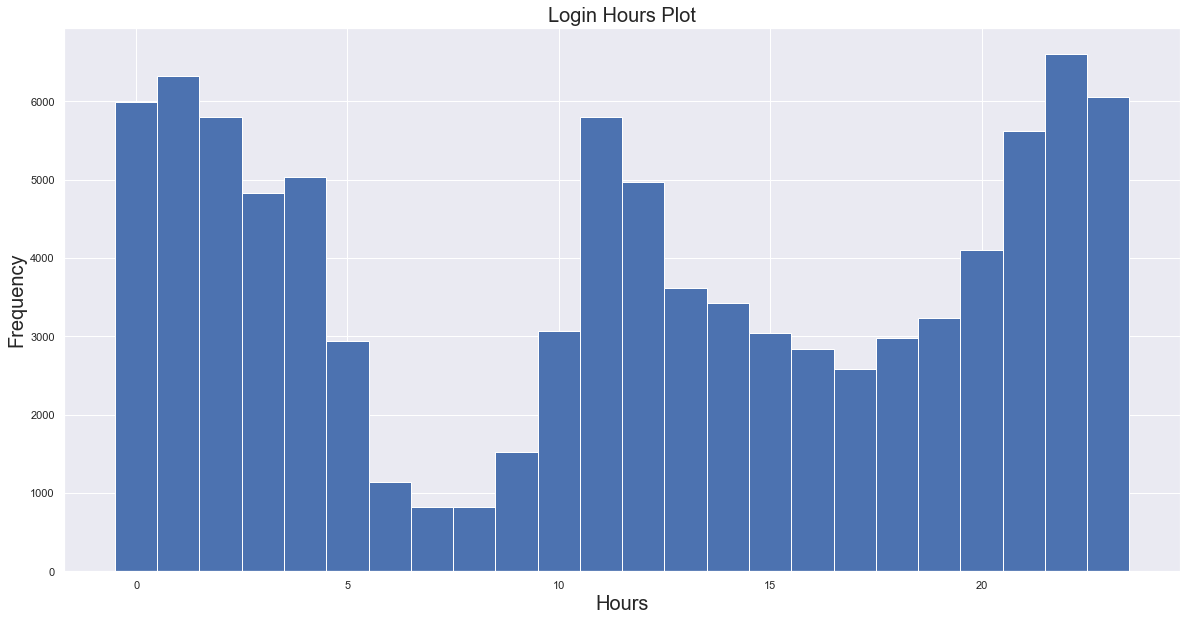

In [46]:
df['Hour'] = df.login_time.dt.hour
hourly_logins = df.groupby('Hour', as_index=False).sum()
hourly_logins.sort_values('Counter', ascending=False)

plt.figure(figsize=(20, 10))
plt.bar(hourly_logins.Hour, hourly_logins.Counter, width=1)
plt.xlabel('Hours', size = 20)
plt.ylabel('Frequency',size = 20)
plt.title('Login Hours Plot',size = 20)
sns.set()

**The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.**

**1 What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?**

The measure of success would be a marked increase in driver partners moving between the cities. If the drivers don't move between the cities then there is no use in changing the bridge tolls--indeed, it may result in revenue loss. 

**2 Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the
observation
c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.**

Implement the toll changes for a period of a few months--we want to account for variability of weather, holidays, etc. that might skew data. A full reimbursement of the toll for all driver partners during said period. We want to measure the number of driver partners crossing, yes, but we also want to measure the changes in business activity during each city's "off hours"--day for Gotham, Night for Metropolis. We also want to make sure it makes fiscal sense to maintain the reimbursement, which means that the money spent by people in the cities in the off hours is worth the reimbursement cost.

In [47]:
df_ultimate = pd.read_json('ultimate_data_challenge.json')

In [48]:
df_ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [50]:
df_ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [51]:
print(df_ultimate['avg_rating_of_driver'].min())
print(df_ultimate['avg_rating_of_driver'].max())
print(df_ultimate['avg_rating_by_driver'].min())
print(df_ultimate['avg_rating_by_driver'].max())

1.0
5.0
1.0
5.0


In [53]:
df_ultimate['avg_rating_of_driver'] = df_ultimate['avg_rating_of_driver'].fillna(0)
df_ultimate['avg_rating_by_driver'] = df_ultimate['avg_rating_by_driver'].fillna(0)
df_ultimate['phone'] = df_ultimate['phone'].fillna(df_ultimate['phone'].mode().iloc[0])
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [54]:
df_ultimate['signup_date'] = pd.to_datetime(df_ultimate['signup_date'])
df_ultimate['last_trip_date'] = pd.to_datetime(df_ultimate['last_trip_date'])
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [56]:
df_ultimate.last_trip_date.max() 


Timestamp('2014-07-01 00:00:00')

In [58]:
df_ultimate.last_trip_date.min() 

Timestamp('2014-01-01 00:00:00')

 For our purposes any user active bewteen June 1st and July 1st is an Active User.

In [59]:
df2 = df_ultimate.copy()
target = (df_ultimate.last_trip_date < '2014-06-01').astype(int)
target.name = 'target'
target

0        0
1        1
2        1
3        0
4        1
        ..
49995    0
49996    1
49997    1
49998    1
49999    1
Name: target, Length: 50000, dtype: int32

In [61]:
city_one_hot = pd.get_dummies(df2.city)
df2.phone = pd.get_dummies(df2.phone, drop_first=True)
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [62]:
days_active = pd.to_datetime(df2.last_trip_date).subtract(pd.to_datetime(df2.signup_date)) / np.timedelta64(1, 'D')
days_active.name = 'days_active'
df2.ultimate_black_user = (df2.ultimate_black_user).astype(int)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  uint8         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(1), in

In [63]:
df2 = df2.drop(columns=['city', 'signup_date', 'last_trip_date'])
df2

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,4,4.7,1.10,1,15.4,1,46.2,3.67,5.0
1,0,5.0,1.00,0,0.0,0,50.0,8.26,5.0
2,3,4.3,1.00,1,0.0,0,100.0,0.77,5.0
3,9,4.6,1.14,1,20.0,1,80.0,2.36,4.9
4,14,4.4,1.19,0,11.8,0,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,1,0.0,0,100.0,5.63,4.2
49996,1,0.0,1.00,1,0.0,0,0.0,0.00,4.0
49997,0,5.0,1.00,0,0.0,1,100.0,3.86,5.0
49998,2,3.0,1.00,1,0.0,0,100.0,4.58,3.5


In [65]:
df_final = pd.concat([df2, city_one_hot, days_active, target], axis=1)
df_final

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,days_active,target
0,4,4.7,1.10,1,15.4,1,46.2,3.67,5.0,0,1,0,143.0,0
1,0,5.0,1.00,0,0.0,0,50.0,8.26,5.0,1,0,0,96.0,1
2,3,4.3,1.00,1,0.0,0,100.0,0.77,5.0,1,0,0,1.0,1
3,9,4.6,1.14,1,20.0,1,80.0,2.36,4.9,0,1,0,170.0,0
4,14,4.4,1.19,0,11.8,0,82.4,3.13,4.9,0,0,1,47.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,1,0.0,0,100.0,5.63,4.2,0,1,0,131.0,0
49996,1,0.0,1.00,1,0.0,0,0.0,0.00,4.0,1,0,0,1.0,1
49997,0,5.0,1.00,0,0.0,1,100.0,3.86,5.0,0,0,1,111.0,1
49998,2,3.0,1.00,1,0.0,0,100.0,4.58,3.5,1,0,0,1.0,1


Now we have the data tidy, so it is not only easy to access whether or not a user was active in the last 30 days, but also to see where the user went, whether or not the user has Ultimate Black, etc.. The data is now ready for modeling.

In [66]:

x = df_final.iloc[:,:-1].values
y = df_final.target.values


sc = StandardScaler()
x = sc.fit_transform(x)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)


model = LogisticRegression()
model.fit(x_train, y_train)


y_pred = model.predict(x_test)

In [67]:
cm = confusion_matrix(y_test, y_pred)
print('Accuracy:', model.score(x_test, y_test))
print('AUC:', roc_auc_score(y_test, y_pred))
print('Confusion Matrix:')
print(cm)

Accuracy: 0.96
AUC: 0.9585652357471419
Confusion Matrix:
[[3485  171]
 [ 229 6115]]


In [70]:
model_weights = pd.DataFrame({'features' : dataset.iloc[:,:-1].columns.tolist(), 'weight' : model.coef_.tolist()[0]})


In [71]:
model_weights.sort_values(by='weight')


,features,weight
12,days_active,-12.345470
10,King's Landing,-0.434001
5,ultimate_black_user,-0.379120
3,phone,-0.357276
0,trips_in_first_30_days,-0.250606
2,avg_surge,-0.061156
7,avg_dist,0.020882
8,avg_rating_by_driver,0.042514
4,surge_pct,0.083720
1,avg_rating_of_driver,0.087699


The model is fantastically accurate! And what seems to be the heaviest correlation is length of time that a user has been active. That isn't paradoxical, we expect that users who have had the app for a longer time will be more active on it. Ultimate Black seems not to be as strong of an indicator for long term use as Ultimate might like, so, perhaps a reevaluation of the benefits offered by it are in order.